In [1]:
import pycomod as pcm
import numpy as np
import math


In [24]:
class Dune(pcm.Model):
    def build(self):
        
        # gravitational constant
        G = self.parameter(6.6743*1.296*10**2) # changing units to km, hours, exagrams (Eg = 10^18 g)
        
        # a = Arrakis
        # h = Hand of God
        # m = Muad'dib
        
        # Masses
        M_a = self.parameter(4.97*10**9) # Eg
        M_h = self.parameter(1.27*10**6) # Eg
        M_m = self.parameter(1.12*10**5) # Eg
        
        # Radii
        R_a = self.parameter(6128) # km
        R_h = self.parameter(450) # km
        R_m = self.parameter(200) # km
        
                
        # Orbital distances
        L_ah = self.parameter(103000) # km
        L_am = self.parameter(324077) # km
        
        
        
        
        

        

        
        # Initial positions and velocities
        Px_a = self.pool(-L_ah*M_h/(M_a+M_h), allow_neg=True)
        Py_a = self.pool(0, allow_neg=True)
        Vx_a = self.pool(0, allow_neg=True)
        Vy_a = self.pool(0, allow_neg=True)
        
        Px_h = self.pool(L_ah*M_a/(M_a+M_h), allow_neg=True) # km
        Py_h = self.pool(0, allow_neg=True)
        Vx_h = self.pool(0, allow_neg=True)
        Vy_h = self.pool((G*M_a/L_ah)**0.5, allow_neg=True) # km/hr
        
        Px_m = self.pool(L_am, allow_neg=True)
        Py_m = self.pool(0, allow_neg=True)
        Vx_m = self.pool(0, allow_neg=True)
        Vy_m = self.pool((G*M_a/L_am)**0.5, allow_neg=True)
        
        
        # equations
        # Arrakis - HoG
        Dx_ah = self.equation(lambda: Px_h - Px_a) # delta between bodies
        Dy_ah = self.equation(lambda: Py_h - Py_a)
        
        D2_ah = self.equation(lambda: Dx_ah**2 + Dy_ah**2) # distance sq
        D_ah = self.equation(lambda: D2_ah**0.5) # distance
        
        Nx_ah = self.equation(lambda: Dx_ah/D_ah) # normalized delta
        Ny_ah = self.equation(lambda: Dy_ah/D_ah)
        
        
        # Arrakis - Muad'dib
        Dx_am = self.equation(lambda: Px_m - Px_a) # delta between bodies
        Dy_am = self.equation(lambda: Py_m - Py_a)
        
        D2_am = self.equation(lambda: Dx_am**2 + Dy_am**2) # distance sq
        D_am = self.equation(lambda: D2_am**0.5) # distance
        
        Nx_am = self.equation(lambda: Dx_am/D_am) # normalized delta
        Ny_am = self.equation(lambda: Dy_am/D_am)
        
       
        # HoG - Muad'dib
        Dx_hm = self.equation(lambda: Px_m - Px_h) # delta between bodies
        Dy_hm = self.equation(lambda: Py_m - Py_h)
        
        D2_hm = self.equation(lambda: Dx_hm**2 + Dy_hm**2) # distance sq
        D_hm = self.equation(lambda: D2_hm**0.5) # distance
        
        Nx_hm = self.equation(lambda: Dx_hm/D_hm) # normalized delta
        Ny_hm = self.equation(lambda: Dy_hm/D_hm)
        
    
        # flows
    
        Fvx_h = self.flow(lambda: -G*(M_a*Nx_ah/D2_ah - M_m*Nx_hm/D2_hm) -Vx_h*0.0002, dest=Vx_h) # velocity update on HoG from Arrakis
        Fvy_h = self.flow(lambda: -G*(M_a*Ny_ah/D2_ah - M_m*Ny_hm/D2_hm) -Vy_h*0.0002, dest=Vy_h)
        
        Fpx_h = self.flow(lambda: -G/2*(M_a*Nx_ah/D2_ah - M_m*Nx_hm/D2_hm)*self.dt + Vx_h, dest=Px_h) # position update on HoG from Arrakis
        Fpy_h = self.flow(lambda: -G/2*(M_a*Ny_ah/D2_ah - M_m*Ny_hm/D2_hm)*self.dt + Vy_h, dest=Py_h)
        


        
        Fvx_m = self.flow(lambda: -G*(M_a*Nx_am/D2_am + M_h*Nx_hm/D2_hm) -Vx_m*0.00001, dest=Vx_m) # velocity update on HoG from Arrakis
        Fvy_m = self.flow(lambda: -G*(M_a*Ny_am/D2_am + M_h*Ny_hm/D2_hm) -Vy_m*0.00001, dest=Vy_m)
        
        Fpx_m = self.flow(lambda: -G/2*(M_a*Nx_am/D2_am + M_h*Nx_hm/D2_hm)*self.dt + Vx_m, dest=Px_m) # position update on HoG from Arrakis
        Fpy_m = self.flow(lambda: -G/2*(M_a*Ny_am/D2_am + M_h*Ny_hm/D2_hm)*self.dt + Vy_m, dest=Py_m)
        
        
        
        
        
                
        
        
        
        
        
        #field grid
        N = 199 # grid divisions
        #L = 200000 #grid spacial range from origin
        L = 15000
        
        Gx = [L_ah -L + x/N*2*L for x in range(N+1)]
        Gy = [-L + x/N*2*L for x in range(N+1)]
        
        W = math.sqrt(G*M_a/L_ah**3) #angular velocity of Arrakis HoG frame
        
        Fx = [0]*(N+1)
        Fy = [0]*(N+1)
        for j in range(N+1):   
            Fx[j] = [0]*(N+1)
            Fy[j] = [0]*(N+1)
            for i in range(N+1):
                px = self.parameter(Gx[i])
                py = self.parameter(Gy[j])
                
                ax = self.parameter(px - Px_a)
                ay = self.parameter(py - Py_a)
                
                hx = self.parameter(px - Px_h)
                hy = self.parameter(py - Py_h)
                
                #Fx[j][i] = self.equation(lambda: W*px - G*M_a*px/(px**2 + py**2)**2 - G*M_h*ux/(ux**2 + uy**2)**2)
                #Fy[j][i] = self.equation(lambda: W*py - G*M_a*py/(px**2 + py**2)**2 - G*M_h*uy/(ux**2 + uy**2)**2)
                
                Fx[j][i] = self.equation(lambda: px*W**2 - G*M_a*ax/(ax**2 + ay**2)**1.5 - G*M_h*hx/(hx**2 + hy**2)**1.5)
                Fy[j][i] = self.equation(lambda: py*W**2 - G*M_a*ay/(ax**2 + ay**2)**1.5 - G*M_h*hy/(hx**2 + hy**2)**1.5)
                
                #Fx[j][i] = self.equation(lambda: px*W**2 - G*M_a*px/(px**2 + py**2)**1.5)
                #Fy[j][i] = self.equation(lambda: py*W**2 - G*M_a*py/(px**2 + py**2)**1.5)

                
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        self.set_available(locals(), output=(Px_a, Py_a, Px_h, Py_h, D_ah, Dx_ah, Dy_ah))
d = Dune()

In [25]:
mgr = pcm.RunManager()
mgr.run(d, duration=24*0, dt=0.1, tunit=np.timedelta64(1, 'h'), label='My run')

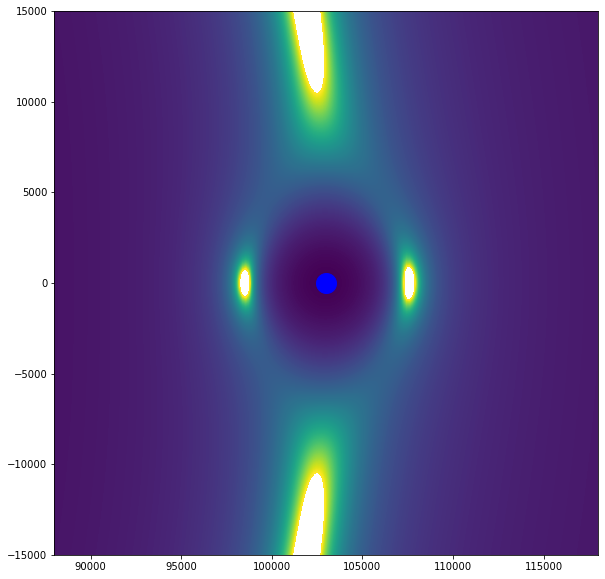

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))


ax.plot(d.Px_a.value_hist, d.Py_a.value_hist, color='red', linewidth=0.5)
ax.plot(d.Px_a.value_hist[-1], d.Py_a.value_hist[-1], color='red', marker='o', markersize=20)

ax.plot(d.Px_h.value_hist, d.Py_h.value_hist, color='blue', linewidth=0.5)
ax.plot(d.Px_h.value_hist[-1], d.Py_h.value_hist[-1], color='blue', marker='o', markersize=20)

ax.plot(d.Px_m.value_hist, d.Py_m.value_hist, color='green', linewidth=0.5)
ax.plot(d.Px_m.value_hist[-1], d.Py_m.value_hist[-1], color='green', marker='o', markersize=4)




#X = d.Gx
#Y = d.Gy
#U, V = np.meshgrid(X, Y)
N = d.N
Fx = [0]*(N+1)
Fy = [0]*(N+1)
for j in range(N+1):
    Fx[j] = [0]*(N+1)
    Fy[j] = [0]*(N+1)
    for i in range(N+1):
        Fx[j][i] = 1/math.sqrt(d.Fx[j][i]()**2 + d.Fy[j][i]()**2)
        #Fy[j][i] = d.Fy[j][i]()
        



ax.contourf(d.Gx, d.Gy, Fx, levels=np.linspace(0, 0.1, 500))
#ax.quiverkey(q, X=0.3, Y=1.1, U=10,
#             label='Quiver key, length = 20', labelpos='E')

#ax.quiver(d.Gx, d.Gy, Fx, Fy, width=0.002)


#ax.set(xlabel='time (s)', ylabel='voltage (mV)',
#       title='About as simple as it gets, folks')
r = 15000
#ax.grid()
ax.set_aspect('equal', 'box')
ax.set_xlim([d.L_ah -r, d.L_ah + r])
ax.set_ylim([-r, r])


plt.show()

In [ ]:
d.Vy_a.value_hist[-1]

In [ ]:
plt = pcm.Plotter(title='Arrakis system', fontsize=14)
plt.plot(mgr['My run'], 'Px_a', color='blue', label='Px_a')
plt.plot(mgr['My run'], 'Py_a', color='cyan', label='Py_a')
plt.plot(mgr['My run'], 'Px_h', color='red', label='Px_h')
plt.plot(mgr['My run'], 'Py_h', color='pink', label='Py_h')

In [ ]:
import math
import matplotlib.pyplot as plt



# gravitational constant
G = 6.6743*1.296*10**2 # changing units to km, hours, exagrams (Eg = 10^18 g)

# a = Arrakis
# h = Hand of God
# m = Muad'dib

# Masses
M_a = 4.97*10**9 # Eg
M_h = 1.27*10**6 # Eg
M_m = 1.12*10**5 # Eg

# Radii
R_a = 6128 # km
R_h = 450 # km
R_m = 200 # km



# Orbital distances
L_ah = 103000 # km
L_am = 324077 # km




fig, ax = plt.subplots(figsize=(8, 8))


m_x = [L_am*math.cos(i*math.pi/50) for i in range(101)]
m_y = [L_am*math.sin(i*math.pi/50) for i in range(101)]

ax.plot([0,], [0,], color='red', marker='o', markersize=20)

ax.plot([L_ah,], [0,], color='blue', marker='o', markersize=9)

ax.plot([L_am,], [0,], color='green', marker='o', markersize=4)

ax.plot(m_x, m_y, color='green', linewidth=0.5)

# lagrange points

# angular velocity of Arrakis - HoG frame
w = math.sqrt(G*M_a/L_ah**3)

# L1









ax.set_aspect('equal', 'box')
ax.set_xlim([-400000, 400000])
ax.set_ylim([-400000, 400000])

plt.show()